# Discriminator Model Performance

This notebook is designed to analyze the discriminator model's performance. Once the generative model labels our data, the discriminator model takes those labels and improves on predictions. For this notebook we are using a generative model trained on Compound binds Gene label functions to predict Compound binds Gene sentences. Performance for each model is reported in area under the receiver operating curve (AUROC) and area under the precision recall curve (AUPR).

In [1]:
import glob
import os
import pandas as pd

import plotnine as p9
import scipy.stats as ss
from sklearn.metrics import auc, precision_recall_curve, roc_curve, precision_recall_fscore_support

# Tune Set

## Performance of Disc model vs Gen model for each Label Sample

In [2]:
dev_labels = pd.read_csv("input/cbg_dev_labels.tsv", sep="\t")
dev_labels.head()

,candidate_id,curated_cbg
0,50527,0.0
1,51441,0.0
2,52167,0.0
3,52188,0.0
4,52221,0.0


In [3]:
candidate_df = (
    pd.read_excel("../data/sentences/sentence_labels_dev.xlsx")
    .sort_values("candidate_id")
    .query("curated_cbg.notnull()")
)
candidate_df.head()

,candidate_id,compound,gene,drugbank_id,entrez_gene_id,sentence,curated_cbg,notes_cbg,curated_cdg,notes_cdg,curated_cug,notes_cug
0,50527,sodium dodecylsulphate,Fab-fragments,DB00815,2187,"the effect of nacl , ( nh4 ) 2so4 , ~~[[1 sodi...",0.0,NaN,0.0,NaN,0.0,NaN
1,51441,cortisone,GH,DB01380,2688,the glycemic response to iv glucose was simila...,0.0,NaN,0.0,NaN,0.0,NaN
2,52167,ouabain-sensitive,ATPase,DB01092,1769,it can be concluded from these studies that th...,0.0,NaN,0.0,NaN,0.0,NaN
3,52188,Mg2,myosin,DB01794,79784,the average dimensions of the filaments grown ...,0.0,NaN,0.0,NaN,0.0,NaN
4,52221,L-phenylalanine,alkaline phosphatase,DB02556,250,sera of several canine patients contained an i...,0.0,NaN,0.0,NaN,0.0,NaN


In [4]:
gen_model_results_dev_df = pd.read_csv(
    "../label_sampling_experiment/results/CbG/results/dev_sampled_results.tsv", 
    sep="\t"
)

In [5]:
disc_model_dict = {}

for value in gen_model_results_dev_df.lf_num.unique():
        
    disc_model_dict[value] = (
        pd.read_csv(f"input/disc_model_run/{value}/tune.tsv", sep="\t")
    )

In [6]:
def get_au_performance(predictions, gold_labels):
    fpr, tpr, _ = roc_curve(
        gold_labels,
        predictions
    )
    
    precision, recall, _ = precision_recall_curve(
        gold_labels,
        predictions
    )
    
    return auc(fpr, tpr), auc(recall, precision)

In [7]:
records = []
for sample in disc_model_dict:
        for column in disc_model_dict[sample].drop("candidate_id", axis=1).columns:
            aucs = get_au_performance(
                disc_model_dict[sample][column], 
                candidate_df
                .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
                .curated_cbg
                .values
            )
            records.append({
                "model": "disc_model",
                "lf_num": int(sample),
                "auroc": aucs[0],
                "aupr": aucs[1]
            })

dev_set_df = (
    pd.DataFrame.from_records(records)
    .append(
        gen_model_results_dev_df
        .drop("lf_sample", axis=1)
        .assign(model="gen_model")
    )
)

In [8]:
dev_set_stats_df = (
    dev_set_df
    .groupby(["lf_num", "model"])
    .agg({
    "auroc": ['mean', 'std'],
    "aupr": ['mean', 'std'],
    "lf_num": len
    })
    .reset_index()
    .fillna(0)
)
dev_set_stats_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'doid_name', 'split'] else col[0] 
    for col in dev_set_stats_df.columns.values
]

critical_val = ss.norm.ppf(0.975)

dev_set_stats_df = (
    dev_set_stats_df
    .assign(
        **{
            'auroc_upper': lambda x: x.auroc_mean + (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'auroc_lower': lambda x: x.auroc_mean - (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_upper': lambda x: x.aupr_mean + (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_lower': lambda x: x.aupr_mean - (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len)
        }
    )
)
dev_set_stats_df

,lf_num,model,auroc_mean,auroc_std,aupr_mean,aupr_std,lf_num_len,auroc_upper,auroc_lower,aupr_upper,aupr_lower
0,0,disc_model,0.557143,0.000000,0.161955,0.000000,1,0.557143,0.557143,0.161955,0.161955
1,0,gen_model,0.621242,0.000000,0.159903,0.000000,1,0.621242,0.621242,0.159903,0.159903
2,1,disc_model,0.577569,0.033096,0.155220,0.029715,50,0.586742,0.568395,0.163457,0.146984
3,1,gen_model,0.637148,0.012431,0.153833,0.008203,50,0.640594,0.633703,0.156106,0.151559
4,6,disc_model,0.645497,0.028264,0.194277,0.028552,50,0.653331,0.637663,0.202191,0.186363
5,6,gen_model,0.653668,0.022557,0.153597,0.013935,50,0.659920,0.647416,0.157460,0.149735
6,11,disc_model,0.658014,0.022194,0.211980,0.031886,50,0.664165,0.651862,0.220818,0.203142
7,11,gen_model,0.654627,0.019873,0.156752,0.012999,50,0.660136,0.649119,0.160355,0.153149
8,16,disc_model,0.648718,0.018281,0.200282,0.027938,49,0.653836,0.643599,0.208104,0.192460
9,16,gen_model,0.650839,0.012625,0.156090,0.013030,50,0.654339,0.647340,0.159702,0.152478


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


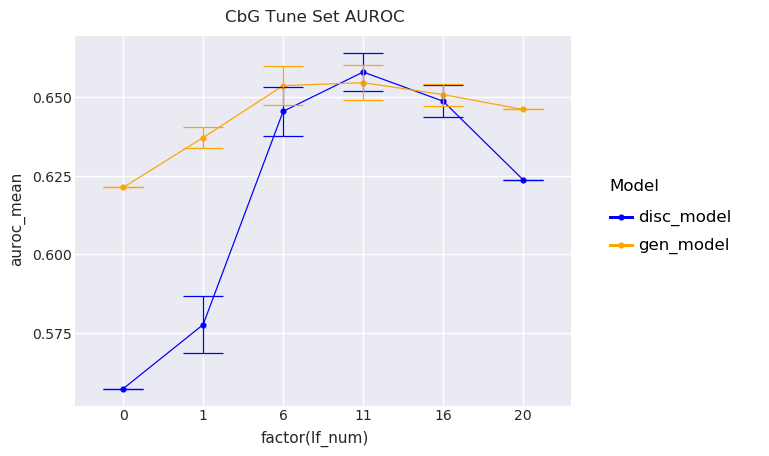

<ggplot: (8774358155279)>

In [9]:
(
    p9.ggplot(dev_set_stats_df, p9.aes(x="factor(lf_num)", y="auroc_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "CbG Tune Set AUROC",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


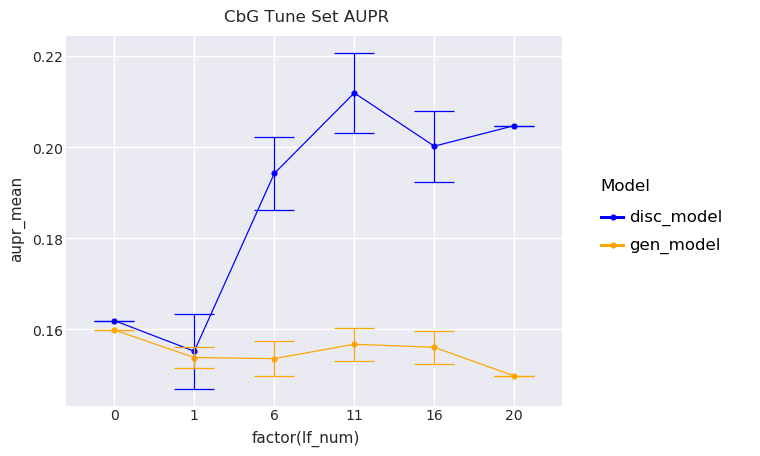

<ggplot: (-9223363262541963618)>

In [10]:
(
    p9.ggplot(dev_set_stats_df, p9.aes(x="factor(lf_num)", y="aupr_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "CbG Tune Set AUPR",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
)

In [11]:
dev_set_df.to_csv("output/dev_set_disc_performance.tsv", sep="\t", index=False)

##  Precision-Recall Improvement over Generative Model

In [12]:
gen_predicton = (
    pd.read_csv(
        "../label_sampling_experiment/results/CbG/marginals/tune/20_sampled_dev.tsv",
        sep="\t"
    )
    .assign(candidate_id=candidate_df.candidate_id.values.tolist())
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .iloc[:,0]
)

In [13]:
disc_precision, disc_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_cbg
    .values, 
    disc_model_dict[20]['0']
)

gen_precision, gen_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_cbg
    .values,
    gen_predicton
)

In [14]:
pr_perform_df = (
    pd.DataFrame(
        {'precision':gen_precision, 'recall':gen_recall}
    )
    .assign(model='gen_model')
    .append(
        pd.DataFrame(
            {'precision':disc_precision, 'recall':disc_recall}
        )
        .assign(model='disc_model')
    )
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


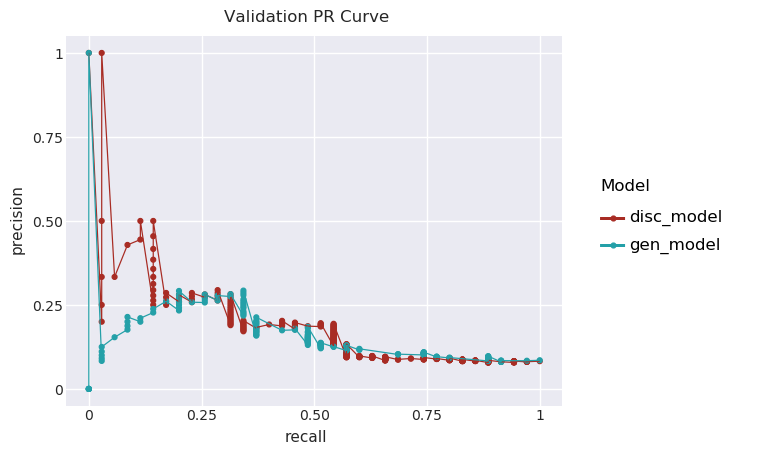

<ggplot: (8774312404807)>

In [15]:
(
    p9.ggplot(pr_perform_df, p9.aes(x="recall", y="precision", color="factor(model)")) +
    p9.geom_point()+ 
    p9.geom_line() + 
    p9.labs(
        title= "Validation PR Curve",
        color="Model"
    )+
    p9.scale_color_discrete(l=.4)+
    p9.theme_seaborn()
)

In [16]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_cbg
    .values, 
    gen_predicton.apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.136, 0.4857142857142857, 0.21250000000000002, None)

In [17]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_cbg
    .values, 
    disc_model_dict[20]['0'].apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.28205128205128205, 0.3142857142857143, 0.29729729729729726, None)

In [18]:
pr_perform_df.to_csv("output/dev_set_pr_performance.tsv", sep="\t", index=False)

# Test Set

## Performance of Disc model vs Gen model for each Label Sample

In [19]:
test_labels = pd.read_csv("input/cbg_test_labels.tsv", sep="\t")
test_labels.head()

,candidate_id,curated_cbg
0,50759,0.0
1,51021,0.0
2,51223,0.0
3,51474,0.0
4,51485,0.0


In [20]:
candidate_df = (
    pd.read_excel("../data/sentences/sentence_labels_test.xlsx")
    .sort_values("candidate_id")
    .query("curated_cbg.notnull()")
)
candidate_df.head()

,candidate_id,compound,gene,drugbank_id,entrez_gene_id,sentence,curated_cbg,notes_cbg,curated_cdg,notes_cdg,curated_cug,notes_cug
31,50759,arginine,C5a,DB04027,728,"the spasmogenic , tachyphylactic , and vascula...",0.0,NaN,0.0,NaN,0.0,NaN
32,51021,bicarbonate,transferrin,DB01390,7018,in an attempt to imitate conditions in the inf...,0.0,NaN,0.0,NaN,0.0,NaN
33,51223,apomorphine,GH,DB00714,2688,injection of ~~[[1 apomorphine 1]]~~ 0.75 mg e...,0.0,NaN,0.0,NaN,1.0,NaN
34,51474,arachidonate,Catalase,DB04557,847,~~[[2 catalase 2]]~~ diminished the absorbance...,0.0,NaN,0.0,NaN,0.0,NaN
35,51485,methylphenidate,growth hormone,DB00422,2688,intravenously administered ~~[[1 methylphenida...,0.0,NaN,0.0,NaN,1.0,NaN


In [21]:
gen_model_results_test_df = pd.read_csv(
    "../label_sampling_experiment/results/CbG/results/test_sampled_results.tsv", 
    sep="\t"
)

In [22]:
disc_model_dict = {}

for value in gen_model_results_test_df.lf_num.unique():

    disc_model_dict[value] = (
        pd.read_csv(f"input/disc_model_run/{value}/test.tsv", sep="\t")
    )

In [23]:
records = []
for sample in disc_model_dict:
        for column in disc_model_dict[sample].drop("candidate_id", axis=1).columns:
            aucs = get_au_performance(
                disc_model_dict[sample][column],
                candidate_df
                .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
                .curated_cbg
                .values
            )
            records.append({
                "model": "disc_model",
                "lf_num": int(sample),
                "auroc": aucs[0],
                "aupr": aucs[1]
            })

test_set_df = (
    pd.DataFrame.from_records(records)
    .append(
        gen_model_results_test_df
        .drop("lf_sample", axis=1)
        .assign(model="gen_model")
    )
)

In [24]:
test_set_stats_df = (
    test_set_df
    .groupby(["lf_num", "model"])
    .agg({
    "auroc": ['mean', 'std'],
    "aupr": ['mean', 'std'],
    "lf_num": len
    })
    .reset_index()
    .fillna(0)
)
test_set_stats_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'doid_name', 'split'] else col[0] 
    for col in test_set_stats_df.columns.values
]

critical_val = ss.norm.ppf(0.975)

test_set_stats_df = (
    test_set_stats_df
    .assign(
        **{
            'auroc_upper': lambda x: x.auroc_mean + (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'auroc_lower': lambda x: x.auroc_mean - (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_upper': lambda x: x.aupr_mean + (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len),
            'aupr_lower':lambda x: x.aupr_mean - (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len)
        }
    )
)
test_set_stats_df

,lf_num,model,auroc_mean,auroc_std,aupr_mean,aupr_std,lf_num_len,auroc_upper,auroc_lower,aupr_upper,aupr_lower
0,0,disc_model,0.675579,0.000000,0.172155,0.000000,1,0.675579,0.675579,0.172155,0.172155
1,0,gen_model,0.781794,0.000000,0.290519,0.000000,1,0.781794,0.781794,0.290519,0.290519
2,1,disc_model,0.733218,0.063287,0.270612,0.066048,50,0.750760,0.715676,0.288919,0.252304
3,1,gen_model,0.798452,0.026770,0.297640,0.023525,50,0.805872,0.791032,0.304160,0.291119
4,6,disc_model,0.772962,0.065993,0.269515,0.076281,50,0.791254,0.754670,0.290659,0.248372
5,6,gen_model,0.824432,0.031799,0.337325,0.042769,50,0.833246,0.815618,0.349179,0.325470
6,11,disc_model,0.814206,0.044134,0.284392,0.056185,50,0.826439,0.801973,0.299966,0.268819
7,11,gen_model,0.829764,0.023847,0.340859,0.034434,50,0.836374,0.823154,0.350404,0.331315
8,16,disc_model,0.819893,0.032295,0.276349,0.042852,49,0.828935,0.810850,0.288347,0.264351
9,16,gen_model,0.823436,0.018199,0.321312,0.029762,50,0.828480,0.818391,0.329561,0.313062


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


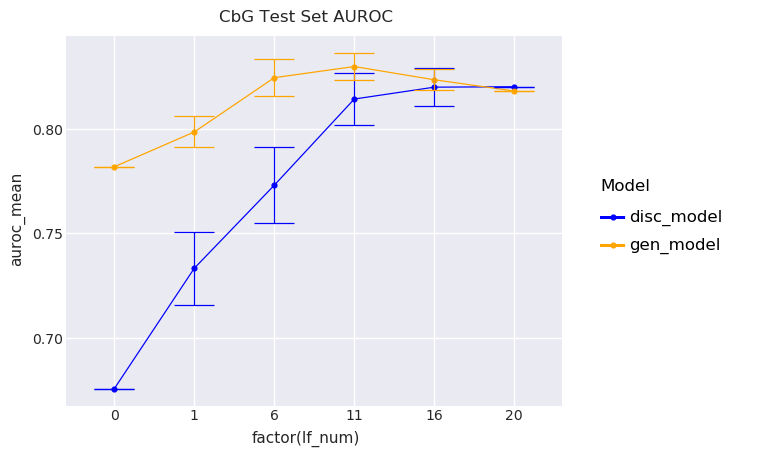

<ggplot: (-9223363262542308222)>

In [25]:
(
    p9.ggplot(test_set_stats_df, p9.aes(x="factor(lf_num)", y="auroc_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "CbG Test Set AUROC",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


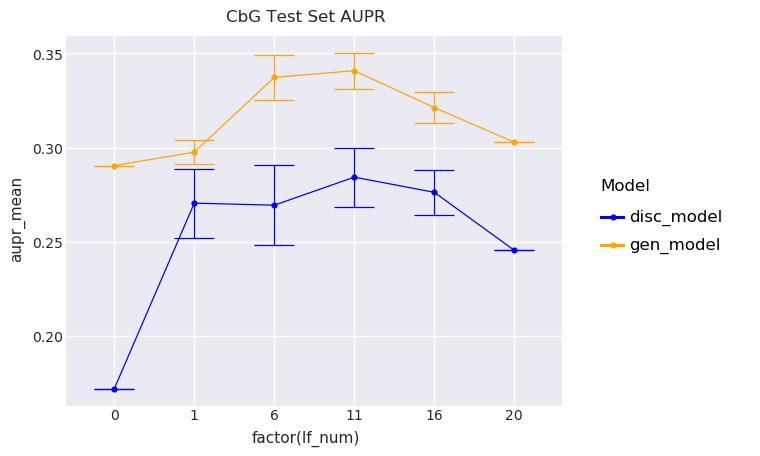

<ggplot: (-9223363262542264134)>

In [26]:
(
    p9.ggplot(test_set_stats_df, p9.aes(x="factor(lf_num)", y="aupr_mean", color="model"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="model"))
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper", group="model"))
    + p9.theme_seaborn()
    + p9.labs(
        title= "CbG Test Set AUPR",
        color="Model"
    )
    + p9.scale_color_manual({
        "disc_model": "blue",
        "gen_model": "orange"
    })
)

In [27]:
test_set_df.to_csv("output/test_set_disc_performance.tsv", sep="\t", index=False)

##  Precision-Recall Improvement over Generative Model

In [28]:
gen_predicton = (
    pd.read_csv(
        "../label_sampling_experiment/results/CbG/marginals/test/20_sampled_test.tsv",
        sep="\t"
    )
    .assign(candidate_id=candidate_df.candidate_id.values.tolist())
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .iloc[:,0]
)

In [29]:
disc_precision, disc_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_cbg
    .values, 
    disc_model_dict[20]['0']
)
gen_precision, gen_recall, _ = precision_recall_curve(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_cbg
    .values,
    gen_predicton
)

In [30]:
pr_perform_df = (
    pd.DataFrame(
        {'precision':gen_precision, 'recall':gen_recall}
    )
    .assign(model='gen_model')
    .append(
        pd.DataFrame(
            {'precision':disc_precision, 'recall':disc_recall}
        )
        .assign(model='disc_model')
    )
)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


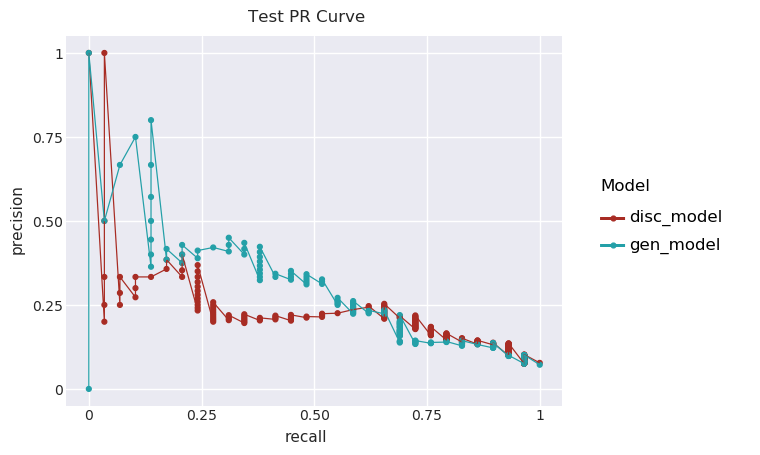

<ggplot: (-9223363262542368887)>

In [31]:
(
    p9.ggplot(pr_perform_df, p9.aes(x="recall", y="precision", color="factor(model)")) +
    p9.geom_point()+ 
    p9.geom_line() + 
    p9.labs(
        title= "Test PR Curve",
        color="Model"
    )+
    p9.scale_color_discrete(l=.4)+
    p9.theme_seaborn()
)

In [32]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_cbg
    .values, 
    gen_predicton.apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.14201183431952663, 0.8275862068965517, 0.24242424242424243, None)

In [33]:
precision_recall_fscore_support(
    candidate_df
    .query(f"candidate_id in {disc_model_dict[value].candidate_id.values.tolist()}")
    .curated_cbg
    .values, 
    disc_model_dict[20]['0'].apply(lambda x: 1 if x > 0.5 else 0),
    average='binary'
)

(0.21739130434782608, 0.6896551724137931, 0.3305785123966942, None)

In [34]:
pr_perform_df.to_csv("output/test_set_pr_performance.tsv", sep="\t", index=False)